In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import accuracy_score

In [2]:
x_train = np.array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
y_train = np.array([[0],
           [1],
           [1],
           [0]])
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4)

In [3]:
def convert2_zero_one(x):
    
    t = tf.math.sigmoid(x)
    #t = tf.cast(tf.math.greater(samples[0], 0.5), tf.int32)
    
    return t

In [4]:
def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tf.math.greater(tf.math.abs(x), r), tf.float32)
    sign = tf.math.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [5]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
    
    def call(self, x):
        
        #x = Flatten()(x)
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_current = [h_current[0]]
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_current = [h_current[0]]
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = h_current[0]

        # initialize the HMC transition kernel
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = pow(1000, -1/4)),
            num_adaptation_steps=int(100*0.8))

        # run the chain (with burn-in)
        num_results = 1
        num_burnin_steps = 100

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = adaptive_hmc,
            trace_fn = None)

        h_new = tf.split(samples[0], self.hidden_layer_sizes, axis = 1)

        return(h_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tf.math.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tf.math.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tf.math.greater(probs, 0.5), tf.int32)

        return labels

In [16]:
model = StochasticMLP(hidden_layer_sizes = [2], n_outputs=1)

In [17]:
network = [model.call(images) for images, labels in train_ds]

In [18]:
# Set weight
w_0 = np.array([[1, -1], [1, -1]], dtype = "float32")
b_0 = np.array([-0.5, 1], dtype = "float32")
l_0 = [w_0, b_0]

w_1 = np.array([[1], [1]], dtype = "float32")
b_1 = np.array([-1], dtype = "float32")
l_1 = [w_1, b_1]

model.fc_layers[0].set_weights(l_0)
model.output_layer.set_weights(l_1)

In [19]:
network = [model.call(images) for images, labels in train_ds]
network

[[<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
  array([[0, 1],
         [0, 1],
         [1, 1],
         [0, 0]], dtype=int32)>]]

In [20]:
kernels = [model.generate_hmc_kernel(images, labels) for images, labels in train_ds]

In [21]:
burnin = 1000
step_sizes = []
for i in range(burnin):
    
    network_new = []
    kernels_new = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        net_current = net_current[0]
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2].new_step_size.numpy()
        step_sizes.append(new_step_size)
        
        new_state = rerange(samples[0][0])
        net_new = tf.split(new_state, [2], axis = 1)   
        network_new.append(net_new)
        
        # build new kernel
        ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new.append(ker_new)
            
    network = network_new
    kernels = kernels_new
    
    #print(network[0])

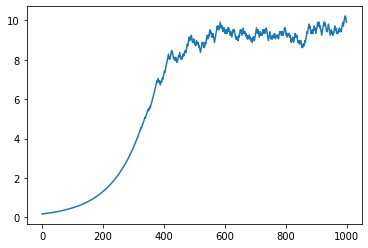

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes)), step_sizes)
plt.show()

In [23]:
print(network[0])

[<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-3.3686607, -6.       ],
       [-6.       ,  6.       ],
       [ 6.       ,  6.       ],
       [-6.       , -4.750222 ]], dtype=float32)>]


In [25]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(images, network[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #               zip(train_ds, network)]
        
        network_new = []
        #kernels_new = []
        for net, hmc_kernel in zip(network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = net_current[0]
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [2], axis = 1)   
            network_new.append(net_new)

        network = network_new
        
        loss += -1 * tf.reduce_mean(model.target_log_prob(images, network[bs], labels))
    
    preds = [model.get_predictions(images) for images, labels in train_ds]
    #print(preds)
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

Epoch 1/500: - 0.0592s/step - loss: 1.9642 - accuracy: 0.7500
Epoch 2/500: - 0.0723s/step - loss: 2.3294 - accuracy: 0.7500
Epoch 3/500: - 0.0627s/step - loss: 1.2504 - accuracy: 0.7500
Epoch 4/500: - 0.0577s/step - loss: 1.2359 - accuracy: 0.7500
Epoch 5/500: - 0.0552s/step - loss: 1.2233 - accuracy: 0.7500
Epoch 6/500: - 0.0548s/step - loss: 1.2148 - accuracy: 0.7500
Epoch 7/500: - 0.0525s/step - loss: 1.2034 - accuracy: 0.7500
Epoch 8/500: - 0.0504s/step - loss: 0.8130 - accuracy: 0.7500
Epoch 9/500: - 0.0490s/step - loss: 0.8114 - accuracy: 0.7500
Epoch 10/500: - 0.0477s/step - loss: 0.8086 - accuracy: 0.7500
Epoch 11/500: - 0.0482s/step - loss: 0.8071 - accuracy: 0.7500
Epoch 12/500: - 0.0482s/step - loss: 0.8057 - accuracy: 0.7500
Epoch 13/500: - 0.0478s/step - loss: 0.8042 - accuracy: 0.7500
Epoch 14/500: - 0.0472s/step - loss: 0.8028 - accuracy: 0.7500
Epoch 15/500: - 0.0466s/step - loss: 1.2814 - accuracy: 0.7500
Epoch 16/500: - 0.0463s/step - loss: 1.2676 - accuracy: 0.7500
E

Epoch 134/500: - 0.0497s/step - loss: 1.0932 - accuracy: 1.0000
Epoch 135/500: - 0.0496s/step - loss: 1.0874 - accuracy: 1.0000
Epoch 136/500: - 0.0496s/step - loss: 1.0826 - accuracy: 1.0000
Epoch 137/500: - 0.0500s/step - loss: 1.0768 - accuracy: 1.0000
Epoch 138/500: - 0.0502s/step - loss: 1.0742 - accuracy: 1.0000
Epoch 139/500: - 0.0503s/step - loss: 1.0695 - accuracy: 1.0000
Epoch 140/500: - 0.0502s/step - loss: 1.6803 - accuracy: 1.0000
Epoch 141/500: - 0.0502s/step - loss: 1.6672 - accuracy: 1.0000
Epoch 142/500: - 0.0501s/step - loss: 1.6521 - accuracy: 1.0000
Epoch 143/500: - 0.0502s/step - loss: 1.0420 - accuracy: 1.0000
Epoch 144/500: - 0.0503s/step - loss: 1.0380 - accuracy: 1.0000
Epoch 145/500: - 0.0504s/step - loss: 0.8022 - accuracy: 1.0000
Epoch 146/500: - 0.0505s/step - loss: 0.7999 - accuracy: 1.0000
Epoch 147/500: - 0.0505s/step - loss: 0.7955 - accuracy: 1.0000
Epoch 148/500: - 0.0505s/step - loss: 1.1127 - accuracy: 1.0000
Epoch 149/500: - 0.0504s/step - loss: 1.

Epoch 265/500: - 0.0533s/step - loss: 0.7019 - accuracy: 1.0000
Epoch 266/500: - 0.0533s/step - loss: 0.7023 - accuracy: 1.0000
Epoch 267/500: - 0.0533s/step - loss: 0.7011 - accuracy: 1.0000
Epoch 268/500: - 0.0533s/step - loss: 0.6979 - accuracy: 1.0000
Epoch 269/500: - 0.0532s/step - loss: 0.6968 - accuracy: 1.0000
Epoch 270/500: - 0.0532s/step - loss: 0.6956 - accuracy: 1.0000
Epoch 271/500: - 0.0532s/step - loss: 1.2737 - accuracy: 1.0000
Epoch 272/500: - 0.0533s/step - loss: 1.2558 - accuracy: 1.0000
Epoch 273/500: - 0.0532s/step - loss: 1.2399 - accuracy: 1.0000
Epoch 274/500: - 0.0532s/step - loss: 1.2247 - accuracy: 1.0000
Epoch 275/500: - 0.0532s/step - loss: 0.6930 - accuracy: 1.0000
Epoch 276/500: - 0.0533s/step - loss: 0.6920 - accuracy: 1.0000
Epoch 277/500: - 0.0533s/step - loss: 0.6898 - accuracy: 1.0000
Epoch 278/500: - 0.0534s/step - loss: 0.6888 - accuracy: 1.0000
Epoch 279/500: - 0.0534s/step - loss: 0.6878 - accuracy: 1.0000
Epoch 280/500: - 0.0534s/step - loss: 0.

Epoch 395/500: - 0.0542s/step - loss: 1.2739 - accuracy: 1.0000
Epoch 396/500: - 0.0543s/step - loss: 0.6072 - accuracy: 1.0000
Epoch 397/500: - 0.0543s/step - loss: 0.6065 - accuracy: 1.0000
Epoch 398/500: - 0.0543s/step - loss: 0.6058 - accuracy: 1.0000
Epoch 399/500: - 0.0543s/step - loss: 0.6051 - accuracy: 1.0000
Epoch 400/500: - 0.0543s/step - loss: 0.6044 - accuracy: 1.0000
Epoch 401/500: - 0.0543s/step - loss: 0.6037 - accuracy: 1.0000
Epoch 402/500: - 0.0544s/step - loss: 0.6031 - accuracy: 1.0000
Epoch 403/500: - 0.0544s/step - loss: 0.6024 - accuracy: 1.0000
Epoch 404/500: - 0.0544s/step - loss: 0.6017 - accuracy: 1.0000
Epoch 405/500: - 0.0544s/step - loss: 0.6010 - accuracy: 1.0000
Epoch 406/500: - 0.0544s/step - loss: 0.6016 - accuracy: 1.0000
Epoch 407/500: - 0.0544s/step - loss: 0.6009 - accuracy: 1.0000
Epoch 408/500: - 0.0544s/step - loss: 0.6026 - accuracy: 1.0000
Epoch 409/500: - 0.0544s/step - loss: 0.6007 - accuracy: 1.0000
Epoch 410/500: - 0.0544s/step - loss: 0.

In [17]:
print(model.trainable_weights)

[<tf.Variable 'dense/kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[ 3.73042  , -2.611004 ],
       [ 3.599267 , -2.4101195]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([-0.8907312,  3.8896167], dtype=float32)>, <tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[2.8464344],
       [2.8018098]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([-4.36044], dtype=float32)>]


In [32]:
model2 = StochasticMLP(hidden_layer_sizes = [30], n_outputs=1)
network2 = [model2.call(images) for images, labels in train_ds]
kernels2 = [model2.generate_hmc_kernel(images, labels) for images, labels in train_ds]

In [33]:
print(network2)

[[<tf.Tensor: shape=(4, 30), dtype=int32, numpy=
array([[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1],
       [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0]], dtype=int32)>]]


In [34]:
burnin = 1000
step_sizes2 = []
for i in range(burnin):
    
    #print(i)
    network_new2 = []
    kernels_new2 = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network2, kernels2):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        net_current = net_current[0]
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2][4].numpy()
        step_sizes2.append(new_step_size)
        
        new_state = rerange(samples[0][0])
        #print(new_state)
        net_new = tf.split(new_state, [30], axis = 1)   
        network_new2.append(net_new)
        
        # build new kernel
        ker_new = model2.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new2.append(ker_new)
            
    network2 = network_new2
    kernels2 = kernels_new2
    

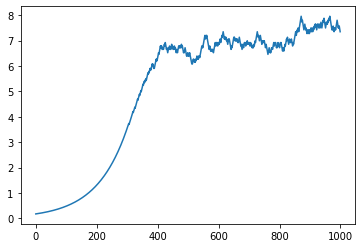

In [35]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes2)), step_sizes2)
plt.show()

In [36]:
print(network2[0])

[<tf.Tensor: shape=(4, 30), dtype=float32, numpy=
array([[-6.        , -6.        ,  6.        , -6.        ,  6.        ,
        -6.        , -6.        , -6.        ,  6.        ,  6.        ,
         4.6416097 ,  6.        , -6.        , -6.        ,  6.        ,
         6.        , -6.        , -6.        ,  6.        ,  6.        ,
        -6.        , -4.2812653 ,  6.        , -6.        , -6.        ,
        -6.        , -6.        , -6.        ,  6.        , -0.46524215],
       [-6.        ,  6.        , -0.09040737, -6.        , -6.        ,
        -6.        ,  6.        , -4.9125853 , -6.        ,  6.        ,
        -6.        ,  6.        ,  4.967575  ,  6.        ,  6.        ,
         5.7838607 , -6.        ,  3.7494664 ,  6.        ,  1.7914963 ,
         6.        ,  6.        , -6.        , -6.        ,  6.        ,
        -5.7645793 , -6.        ,  2.6464858 ,  6.        ,  6.        ],
       [-1.3647175 , -6.        ,  6.        , -1.7725346 ,  2.0486927 ,

In [37]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model2.update_weights(images, network2[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #               zip(train_ds, network)]
        
        network_new2 = []
        for (images, labels), net, hmc_kernel in zip(train_ds, network2, kernels2):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = net_current[0]
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [30], axis = 1)   
            network_new2.append(net_new)
            
        network2 = network_new2
        
        loss += -1 * tf.reduce_mean(model2.target_log_prob(images, network2[bs], labels))
    
    preds = [model2.get_predictions(images) for images, labels in train_ds]
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

Epoch 1/500: - 0.0596s/step - loss: 20.9670 - accuracy: 0.5000
Epoch 2/500: - 0.0575s/step - loss: 20.5372 - accuracy: 0.5000
Epoch 3/500: - 0.0545s/step - loss: 20.3230 - accuracy: 0.5000
Epoch 4/500: - 0.0533s/step - loss: 20.1909 - accuracy: 0.5000
Epoch 5/500: - 0.0547s/step - loss: 19.7377 - accuracy: 0.5000
Epoch 6/500: - 0.0575s/step - loss: 19.4584 - accuracy: 0.5000
Epoch 7/500: - 0.0553s/step - loss: 19.5633 - accuracy: 0.5000
Epoch 8/500: - 0.0540s/step - loss: 19.8760 - accuracy: 0.5000
Epoch 9/500: - 0.0527s/step - loss: 19.2386 - accuracy: 0.5000
Epoch 10/500: - 0.0532s/step - loss: 18.9133 - accuracy: 0.5000
Epoch 11/500: - 0.0524s/step - loss: 19.1469 - accuracy: 0.5000
Epoch 12/500: - 0.0513s/step - loss: 19.4612 - accuracy: 0.5000
Epoch 13/500: - 0.0503s/step - loss: 19.6146 - accuracy: 0.5000
Epoch 14/500: - 0.0498s/step - loss: 19.6077 - accuracy: 0.5000
Epoch 15/500: - 0.0496s/step - loss: 19.0453 - accuracy: 0.5000
Epoch 16/500: - 0.0516s/step - loss: 18.8100 - ac

Epoch 129/500: - 0.0497s/step - loss: 9.2271 - accuracy: 0.5000
Epoch 130/500: - 0.0498s/step - loss: 9.1913 - accuracy: 0.5000
Epoch 131/500: - 0.0498s/step - loss: 9.1562 - accuracy: 0.5000
Epoch 132/500: - 0.0499s/step - loss: 9.1216 - accuracy: 0.5000
Epoch 133/500: - 0.0499s/step - loss: 9.0876 - accuracy: 0.5000
Epoch 134/500: - 0.0499s/step - loss: 9.0541 - accuracy: 0.5000
Epoch 135/500: - 0.0498s/step - loss: 9.0212 - accuracy: 0.5000
Epoch 136/500: - 0.0497s/step - loss: 8.9889 - accuracy: 0.5000
Epoch 137/500: - 0.0497s/step - loss: 8.9570 - accuracy: 0.5000
Epoch 138/500: - 0.0498s/step - loss: 8.9256 - accuracy: 0.5000
Epoch 139/500: - 0.0498s/step - loss: 8.8947 - accuracy: 0.5000
Epoch 140/500: - 0.0498s/step - loss: 8.8643 - accuracy: 0.5000
Epoch 141/500: - 0.0497s/step - loss: 8.8343 - accuracy: 0.5000
Epoch 142/500: - 0.0496s/step - loss: 8.8047 - accuracy: 0.5000
Epoch 143/500: - 0.0496s/step - loss: 8.7756 - accuracy: 0.5000
Epoch 144/500: - 0.0497s/step - loss: 8.

Epoch 261/500: - 0.0517s/step - loss: 7.1620 - accuracy: 0.5000
Epoch 262/500: - 0.0517s/step - loss: 7.1466 - accuracy: 0.5000
Epoch 263/500: - 0.0517s/step - loss: 7.1314 - accuracy: 0.5000
Epoch 264/500: - 0.0517s/step - loss: 7.4262 - accuracy: 0.5000
Epoch 265/500: - 0.0516s/step - loss: 7.3871 - accuracy: 0.5000
Epoch 266/500: - 0.0516s/step - loss: 7.3515 - accuracy: 0.5000
Epoch 267/500: - 0.0516s/step - loss: 7.3186 - accuracy: 0.5000
Epoch 268/500: - 0.0516s/step - loss: 7.2878 - accuracy: 0.5000
Epoch 269/500: - 0.0515s/step - loss: 7.2587 - accuracy: 0.5000
Epoch 270/500: - 0.0515s/step - loss: 7.2310 - accuracy: 0.5000
Epoch 271/500: - 0.0514s/step - loss: 7.2045 - accuracy: 0.5000
Epoch 272/500: - 0.0514s/step - loss: 7.1789 - accuracy: 0.5000
Epoch 273/500: - 0.0514s/step - loss: 7.1542 - accuracy: 0.5000
Epoch 274/500: - 0.0514s/step - loss: 7.1301 - accuracy: 0.5000
Epoch 275/500: - 0.0514s/step - loss: 7.1067 - accuracy: 0.5000
Epoch 276/500: - 0.0515s/step - loss: 7.

Epoch 393/500: - 0.0513s/step - loss: 5.6905 - accuracy: 0.7500
Epoch 394/500: - 0.0513s/step - loss: 5.6834 - accuracy: 0.7500
Epoch 395/500: - 0.0513s/step - loss: 5.6763 - accuracy: 0.7500
Epoch 396/500: - 0.0514s/step - loss: 5.6693 - accuracy: 0.7500
Epoch 397/500: - 0.0514s/step - loss: 5.6623 - accuracy: 0.7500
Epoch 398/500: - 0.0514s/step - loss: 5.6553 - accuracy: 0.7500
Epoch 399/500: - 0.0513s/step - loss: 5.6484 - accuracy: 0.7500
Epoch 400/500: - 0.0513s/step - loss: 5.6415 - accuracy: 0.7500
Epoch 401/500: - 0.0513s/step - loss: 5.6347 - accuracy: 0.7500
Epoch 402/500: - 0.0513s/step - loss: 5.6279 - accuracy: 0.7500
Epoch 403/500: - 0.0513s/step - loss: 5.6212 - accuracy: 0.7500
Epoch 404/500: - 0.0514s/step - loss: 5.6145 - accuracy: 0.7500
Epoch 405/500: - 0.0513s/step - loss: 5.6078 - accuracy: 0.7500
Epoch 406/500: - 0.0513s/step - loss: 5.6011 - accuracy: 0.7500
Epoch 407/500: - 0.0513s/step - loss: 5.5946 - accuracy: 0.7500
Epoch 408/500: - 0.0514s/step - loss: 5.

In [3]:
0.0513*445

22.8285

In [3]:
tf.math.sigmoid(6.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9975274>

In [4]:
tf.math.sigmoid(-6.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.002472623>